# 7th_homework

### Import Section

In [1]:
# !pip install shap
# !pip install numba==0.53

import numpy as np
import pandas as pd

from sklearn.datasets import load_wine

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import shap

### Global Settings Section

In [2]:
random_state_global = 0

### Path Section

In [3]:
PATH_DATA = r'data_banknote_authentication.txt'

## 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

**Описание данных:**

Идентификация подделки банктнот по следующим признакам:

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [4]:
list_columns_name = [
    'variance',
    'skewness',
    'curtosis',
    'entropy',
    'forgery'
]

df_data = pd.read_csv(PATH_DATA, names=list_columns_name)

df_data.head()

,variance,skewness,curtosis,entropy,forgery
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 2. сделать обзорный анализ выбранного датасета

In [5]:
df_data.describe()

,variance,skewness,curtosis,entropy,forgery
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   forgery   1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [7]:
df_data.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
forgery     0
dtype: int64

In [8]:
df_data['forgery'].value_counts()

0    762
1    610
Name: forgery, dtype: int64

**Выводы:**

Данные не содержат пропусков, выбросов и аномалий. Целевая переменная "forgery" не является дисбалансной и представляет собой два класса:
- 0 - подлинная курюра;
- 1 - подделка.

## 3. сделать feature engineering

Для работы линейной модели необходимо выполнить стандартизацию признаков. Для дерева решений подобное преобразование не требуется, поэтому подготовим два набора данных.

In [9]:
X = df_data.drop(columns=['forgery'])
y = df_data['forgery']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_global, stratify=y)

ss = StandardScaler()
X_train_sgd = ss.fit_transform(X_train)
X_test_sgd = ss.transform(X_test)

X_train_sgd = pd.DataFrame(X_train_sgd, columns=X_train.columns)
X_test_sgd = pd.DataFrame(X_test_sgd, columns=X_test.columns)

## 4. обучить любой классификатор (какой вам нравится)

### SGDClassifier

In [10]:
%%time

sgd = SGDClassifier(n_jobs=-1)

sgd.fit(X_train_sgd, y_train)
y_pred_sgd = sgd.predict(X_test_sgd)

print(classification_report(y_test, y_pred_sgd))
accuracy_score(y_test, y_pred_sgd)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       153
           1       1.00      0.99      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

Wall time: 4.99 ms


0.9963636363636363

### DecisionTreeClassifier

In [11]:
%%time

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))
accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       153
           1       0.95      0.99      0.97       122

    accuracy                           0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275

Wall time: 5.98 ms


0.9709090909090909

## 5. разобраться с SHAP и построить важности признаков для:

In [12]:
shap.initjs()

## - всего тестового набора данных (summary_plot - дать интерпретацию)

### SGDClassifier

In [13]:
%%time

explainer = shap.LinearExplainer(sgd, X_train_sgd)

Wall time: 998 µs


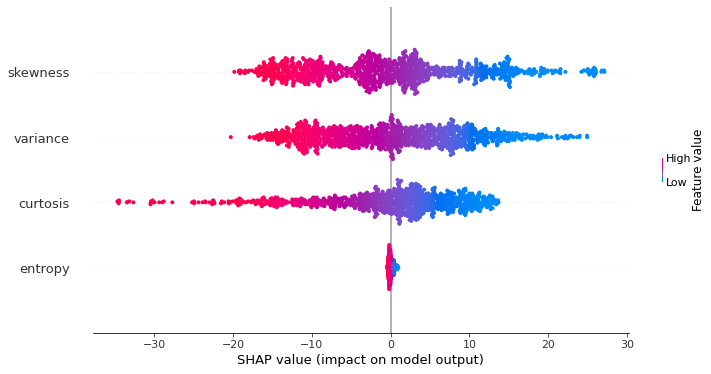

In [14]:
shap.summary_plot(explainer.shap_values(X_train_sgd),
                 features=X_train_sgd, feature_names=X_train.columns,
                 plot_size=(12, 6))

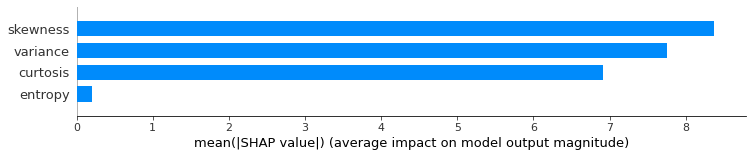

In [15]:
shap.summary_plot(explainer.shap_values(X_train_sgd),
                 features=X_train_sgd, feature_names=X_train.columns,
                 plot_size=(12, 2), plot_type='bar')

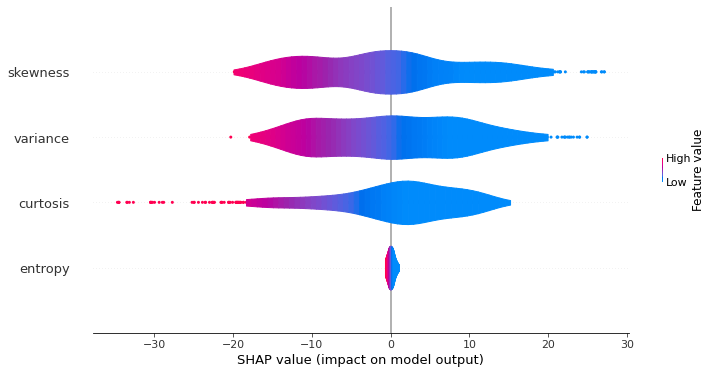

In [16]:
shap.summary_plot(explainer.shap_values(X_train_sgd),
                 features=X_train_sgd, feature_names=X_train.columns,
                 plot_size=(12, 6), plot_type='violin')

**Выводы:**

Линейная модель классификации "SGDClassifier" определила следующие зависимости:

- высокие значения признака "skewness" (асинхронность, скошенность) свидетельствуют, что купюра подлинная (класс 0), низкие - подделка (класс 1);
- высокие значения признака "variance" (дисперсия) свидетельствуют, что купюра подлинная (класс 0), низкие - подделка (класс 1);
- высокие значения признака "curtosis" (острота) свидетельствуют, что купюра подлинная (класс 0), низкие - подделка (класс 1);
- низкие значения признака "entropy" (хаотичность) свидетельствуют, что купюра подлинная (класс 0), высокие - подделка (класс 1).

При этом первые три признака "skewness", "variance" и "curtosis" были определены моделью как наиболее важные для классификации объекта. Четвёртый признак "entropy" был оценён как крайне незначительный.

### DecisionTreeClassifier

In [17]:
%%time

explainer = shap.TreeExplainer(dtc, X_train, feature_names=X_train.columns)

Wall time: 1.02 ms


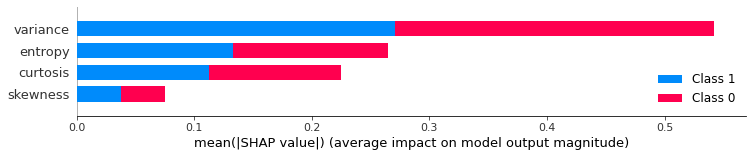

In [18]:
shap.summary_plot(explainer.shap_values(X_train_sgd),
                 features=X_train_sgd, feature_names=X_train.columns,
                 plot_size=(12, 2), plot_type='bar')

**Выводы:**

Модель дерево решений "DecisionTreeClassifier" выявила теже закономерности влияния признаков на целевую переменную, однако иначе оценила вклад признаков:

- значительный вклад был получен от признака "variance", более половины от суммы вкладов всех признаков;
- на втором и третьем местах оказались признаки "entropy" и "curtosis" соответственно с долями вклада около четверти;
- признак "skewness" был оценён как наиболее незначительный.

## для топ 10%

In [19]:
top_10 = int(X_train.shape[0] / 10)

### SGDClassifier

In [20]:
%%time

explainer = shap.LinearExplainer(sgd, X_train_sgd.iloc[:top_10, :])

Wall time: 0 ns


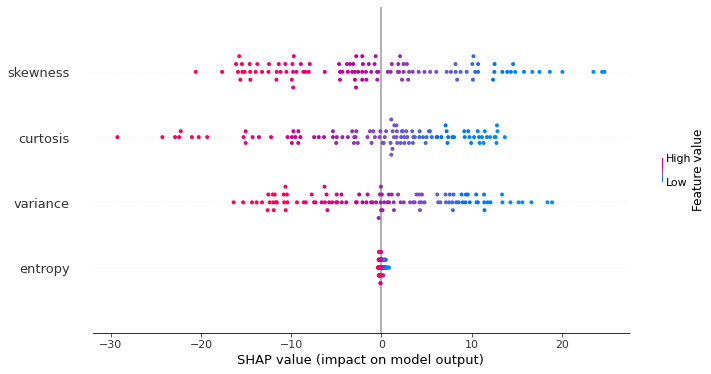

In [21]:
shap.summary_plot(explainer.shap_values(X_train_sgd.iloc[:top_10, :]),
                 features=X_train_sgd.iloc[:top_10, :], feature_names=X_train.columns,
                 plot_size=(12, 6))

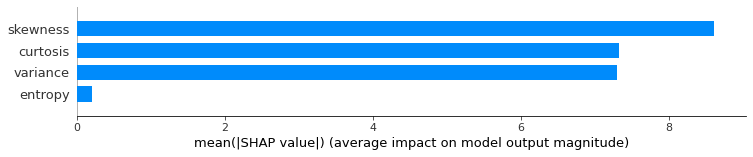

In [22]:
shap.summary_plot(explainer.shap_values(X_train_sgd.iloc[:top_10, :]),
                 features=X_train_sgd.iloc[:top_10, :], feature_names=X_train.columns,
                 plot_size=(12, 2), plot_type='bar')

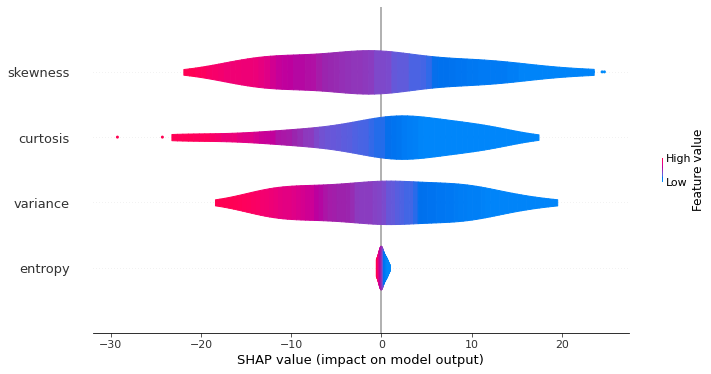

In [23]:
shap.summary_plot(explainer.shap_values(X_train_sgd.iloc[:top_10, :]),
                 features=X_train_sgd.iloc[:top_10, :], feature_names=X_train.columns,
                 plot_size=(12, 6), plot_type='violin')

**Выводы:**

Распределение весов признаков и их влияние на целевую переменную остались неизменны при моделировании на первых 10% выборки.

### DecisionTreeClassifier

In [24]:
%%time

explainer = shap.TreeExplainer(dtc, X_train.iloc[:top_10, :], feature_names=X_train.columns)

Wall time: 996 µs


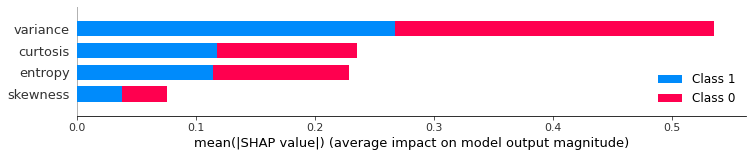

In [25]:
shap.summary_plot(explainer.shap_values(X_train_sgd.iloc[:top_10, :]),
                 features=X_train_sgd.iloc[:top_10, :], feature_names=X_train.columns,
                 plot_size=(12, 2), plot_type='bar')

**Выводы:**

Распределение весов признаков и их влияние на целевую переменную остались неизменны при моделировании на первых 10% выборки.

## 6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### SGDClassifier

In [26]:
%%time

explainer = shap.LinearExplainer(sgd, X_train_sgd)

shap.force_plot(explainer.expected_value, explainer.shap_values(X_train_sgd.iloc[0, :]),
                features=X_train_sgd.iloc[0, :], feature_names=X_train.columns)

Wall time: 997 µs


In [27]:
shap.force_plot(explainer.expected_value, explainer.shap_values(X_train_sgd.iloc[1, :]),
                features=X_train_sgd.iloc[1, :], feature_names=X_train.columns)

### DecisionTreeClassifier

In [28]:
%%time

explainer = shap.TreeExplainer(dtc, X_train, feature_names=X_train.columns)

shap.force_plot(explainer.expected_value[0], explainer.shap_values(X_train.iloc[0, :])[1], feature_names=X_train.columns)

Wall time: 998 µs


In [29]:
# shap.force_plot(explainer.expected_value[0], explainer.shap_values(X_train)[0], feature_names=X_train.columns)
shap.force_plot(explainer.expected_value[0], explainer.shap_values(X_train.iloc[1, :])[1], feature_names=X_train.columns)

**Выводы:**

Для линейной модели классификации "SGDClassifier" в случае с первым объектом признаки "variance", "curtosis", "entropy" повлияли на увеличение вероятности отнесения объекта к классу 1 "подделка". Причём признак "variance" внёс наибольший вклад в увеличение вероятности. Признак "skewness" выступил антиподом - снижал вероятность отнесения объекта к классу 1 "подделка". В случае со вторым объектом наблюдается схожее противоборство признаков, однако в этот раз наибольший вклад внёс признак "curtosis".

Модель дерево решений "DecisionTreeClassifier" демонстрирует отличное влияние признаков на целевую переменную. В случае с первым объектом признак "entropy" понижает вероятность отнесения объекта к классу 1 "подделка", в остальном тенденции схожи с линейной моделью. В классификации второго объекта наблюдается больше отличий: признак "entropy" понижает вероятность, а признак "skewness" повышает. Признаки, вносящие решающий вклад, не изменились для обоих объектов. 